In [15]:
import numpy as np
from numpy import cos as c
from numpy import sin as s

from scipy import integrate
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit
from scipy.stats import gamma
from scipy.stats import lognorm
from scipy.stats import maxwell
# from common_dists import PERT

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterMathtext
plt.style.use("paper.mplstyle")


In [4]:
mc_arr   = np.load("/Users/jlazar/Documents/IceCube/data/mcRecarray.npy")
nuZens   = mc_arr["nuZen"]
nuAzs    = mc_arr["nuAz"]
recoZens = mc_arr["recoZen"]
recoAzs  = mc_arr["recoAz"]
log10nuE = np.log10(mc_arr["nuE"])

In [5]:
log10e_edges = np.linspace(2,6,41)
nue = np.power(10, log10e_edges)
nue_cents = (nue[:-1]+nue[1:])/2.

delta_psi_edges = np.logspace(-4,2,101)
delta_psi_centers = (delta_psi_edges[1:]+delta_psi_edges[:-1])/2.
delta_psi_widths  = delta_psi_edges[1:]-delta_psi_edges[:-1]

In [6]:
def opening_angle(zen1, az1, zen2, az2):
    return np.arccos(np.sin(zen1)*np.sin(zen2)*np.cos(az1-az2)+np.cos(zen1)*np.cos(zen2))

In [7]:
def rotate_coords(nu_az, nu_zen, gen_az, gen_zen):
    reco_x   =  c(nu_az)*c(nu_zen)*c(gen_az)*s(gen_zen) - s(nu_az)*s(gen_az)*s(gen_zen) + c(nu_az)*s(nu_zen)*c(gen_zen)
    reco_y   =  s(nu_az)*c(nu_zen)*c(gen_az)*s(gen_zen) + c(nu_az)*s(gen_az)*s(gen_zen) + s(nu_az)*s(nu_zen)*c(gen_zen)
    reco_z   = -s(nu_zen)*c(gen_az)*s(gen_zen) + c(nu_zen)*c(gen_zen)
    reco_az  = np.arctan(reco_y / reco_x)+np.pi
    reco_zen = np.arccos(reco_z)
    return reco_az, reco_zen

In [8]:
def get_zeros_outta_there(arr):
    arr = np.asarray(arr)
    max_i = np.argmax(arr)
    zeros_i = np.argwhere(arr==0)
    arr1 = np.delete(zeros_i, np.argwhere(zeros_i>max_i))
    arr2 = np.delete(zeros_i, np.argwhere(zeros_i<max_i))
    return max(arr1)+1, min(arr2)

In [9]:
def maxwell(x, a):
    return 4. / (np.sqrt(np.pi)*a**3)*x**2*np.exp(-x**2)

In [10]:
opening_angles = np.degrees(opening_angle(nuZens, nuAzs, recoZens, recoAzs))

1.3692165286617362e-08


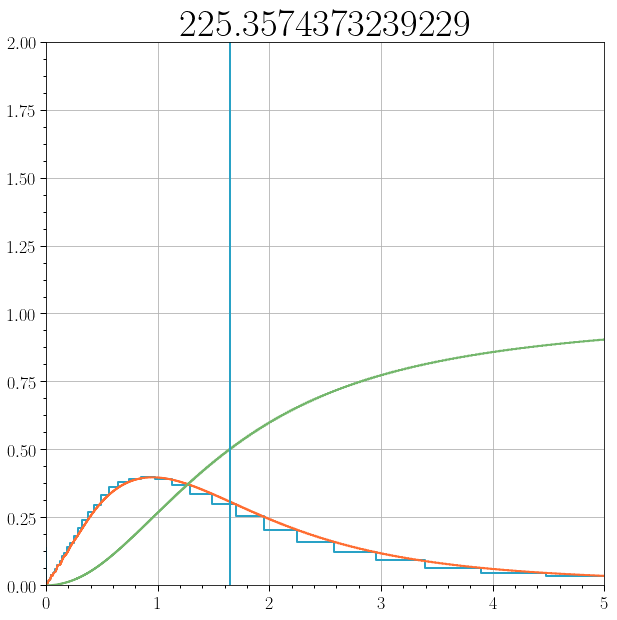

9.234310689089911e-09


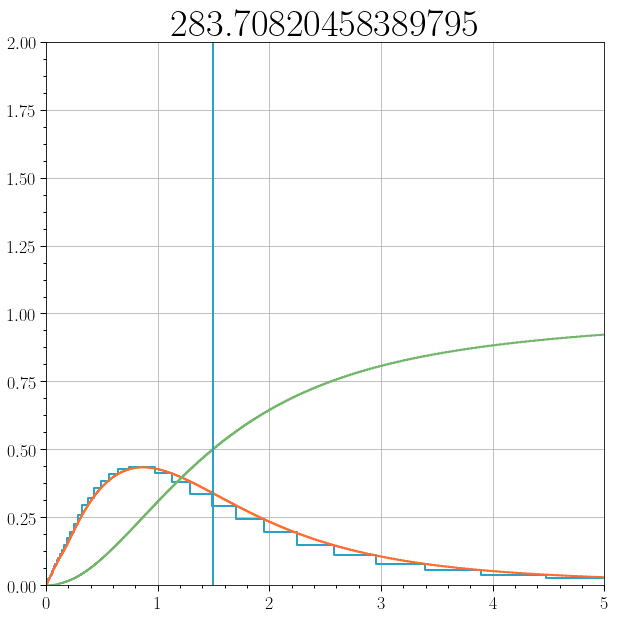

9.979125256231033e-09


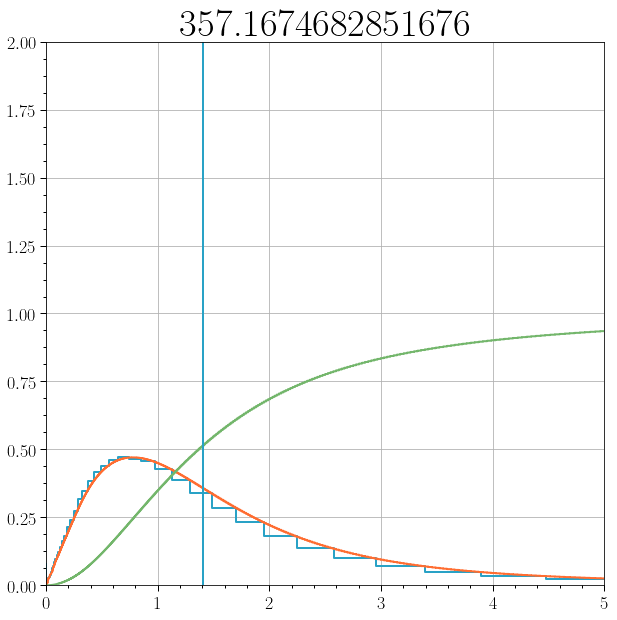

7.4483713897746894e-09


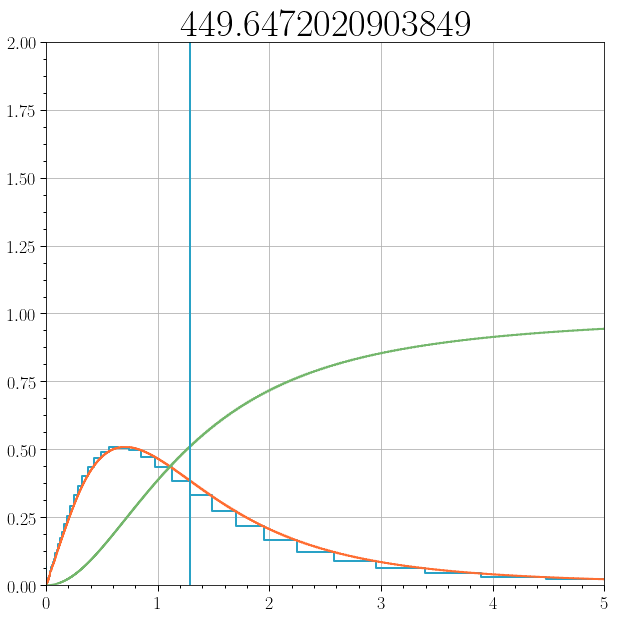

1.4249655758275415e-08


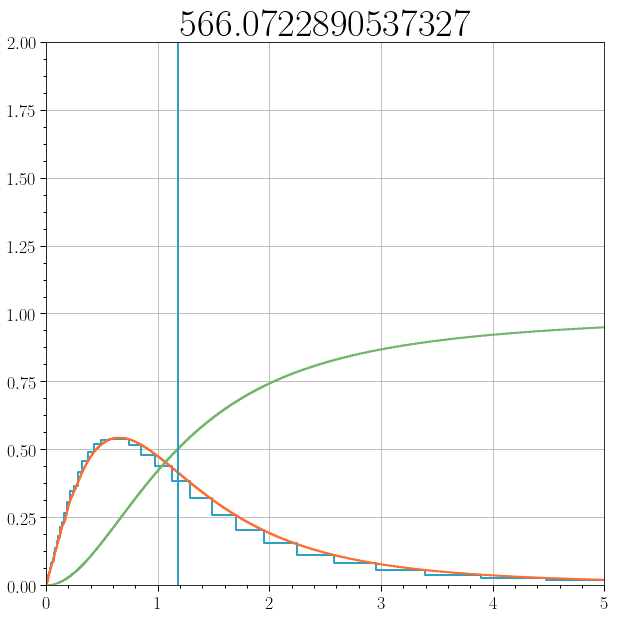

5.780122644645945e-09


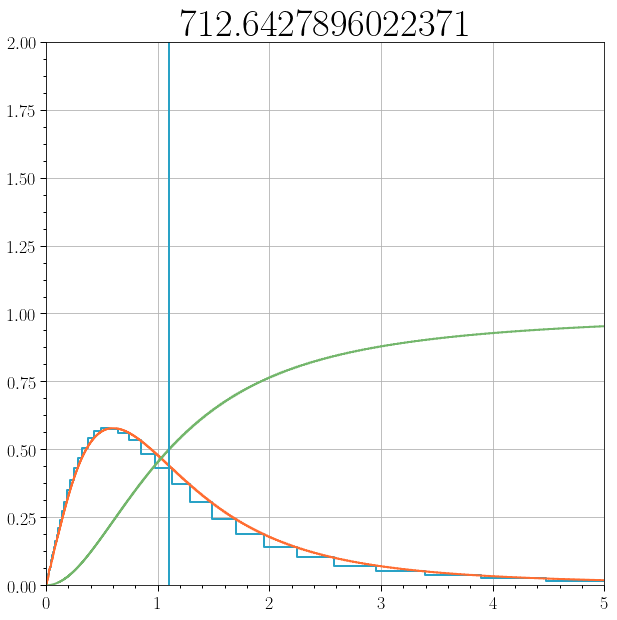

1.0940587198006191e-08


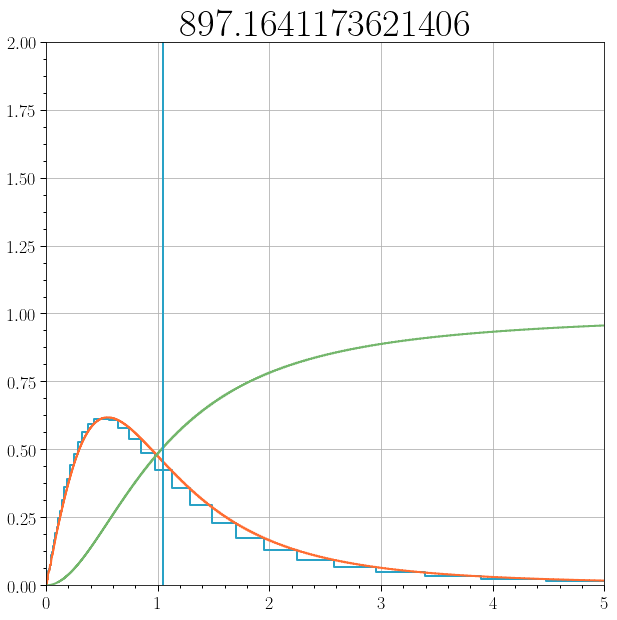

1.426164638879824e-08


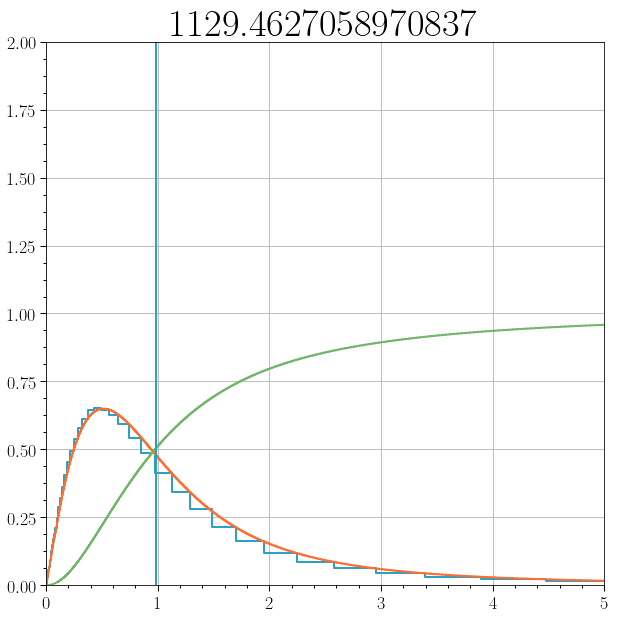

1.0354236382132004e-08


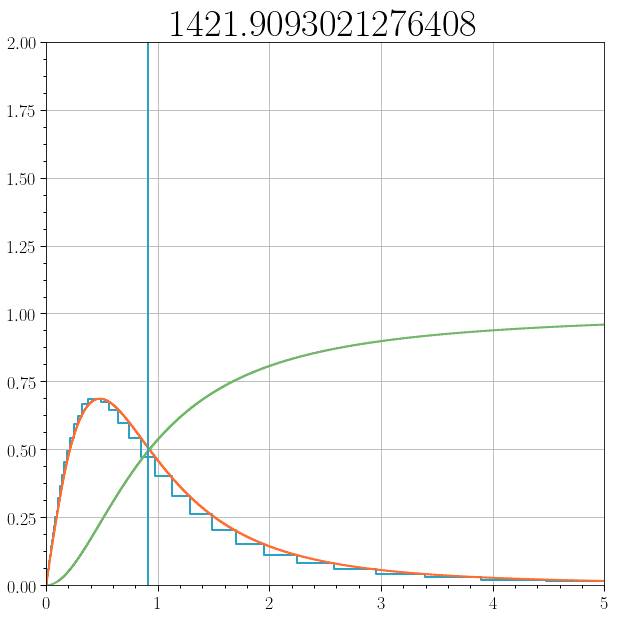

1.009851368811904e-08


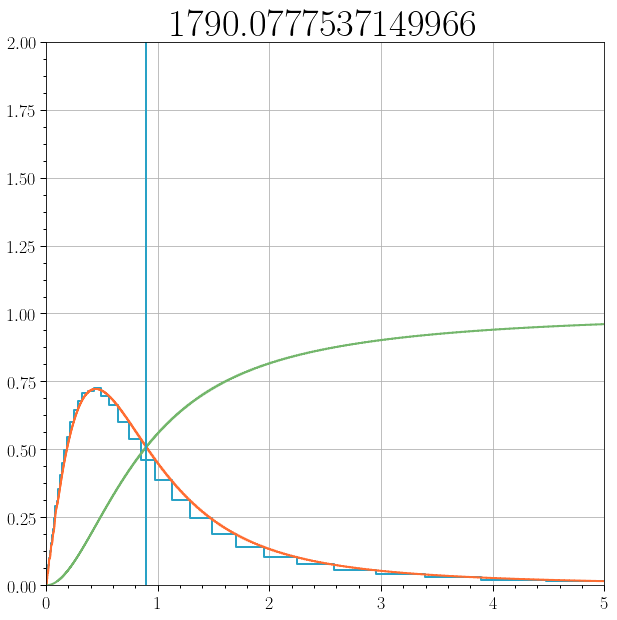

6.197735232572673e-09


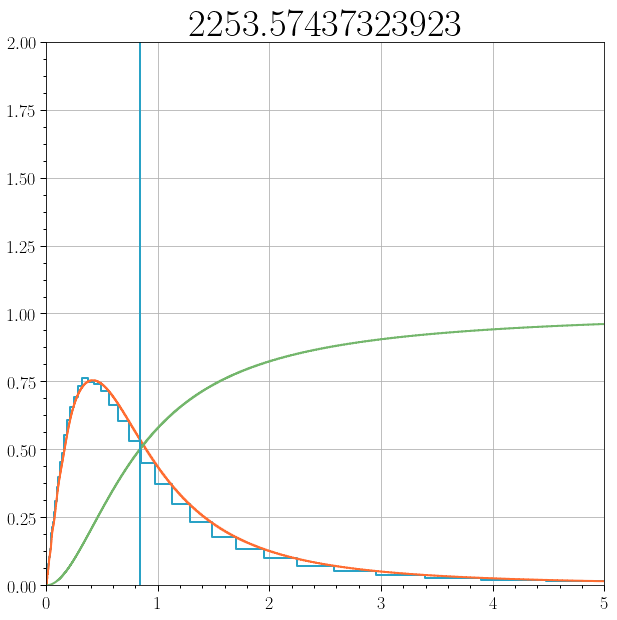

1.3787317849856675e-08


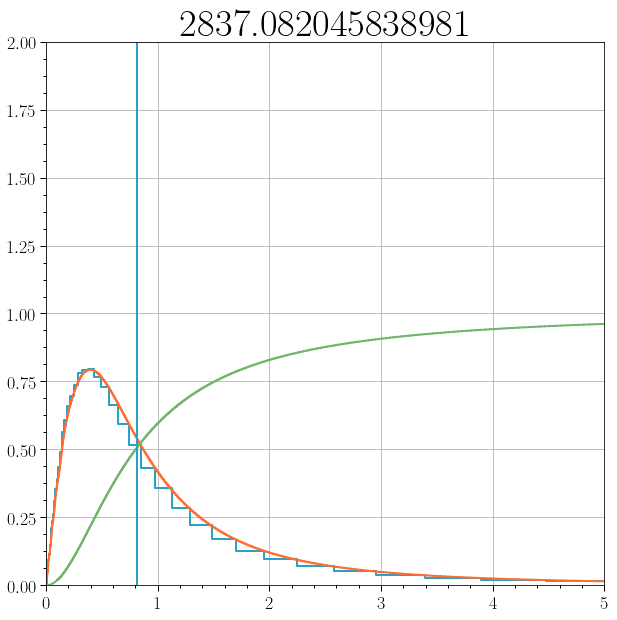

1.0688698227884514e-08


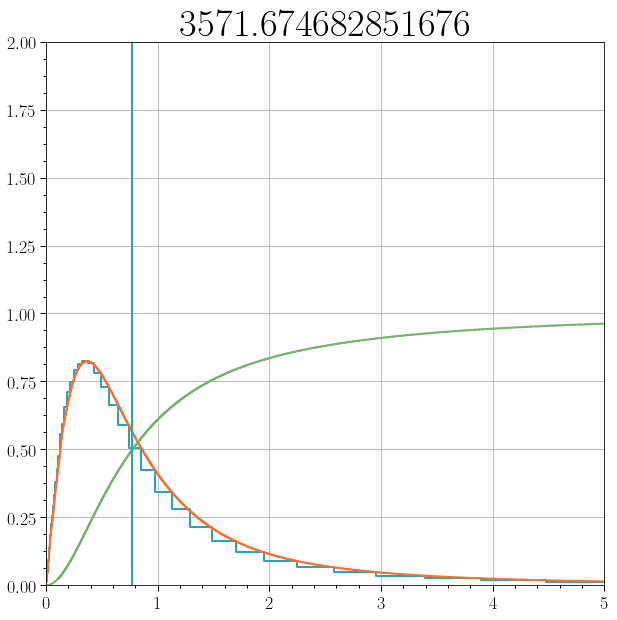

1.3339304022995549e-08


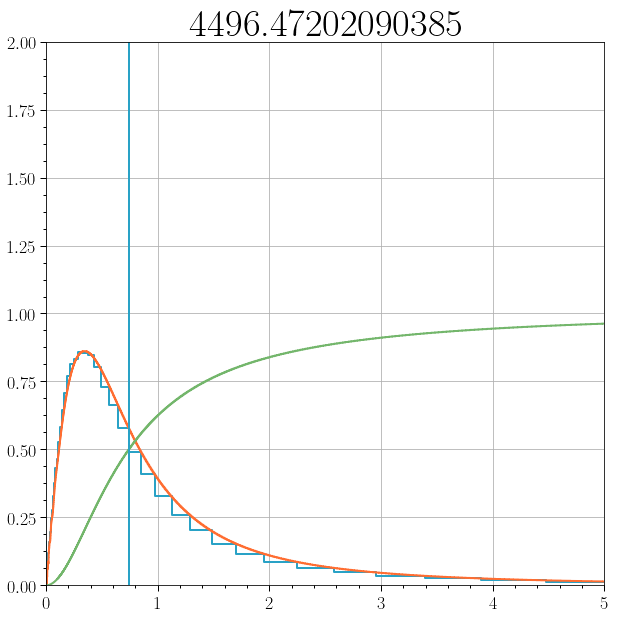

9.887911704024433e-09


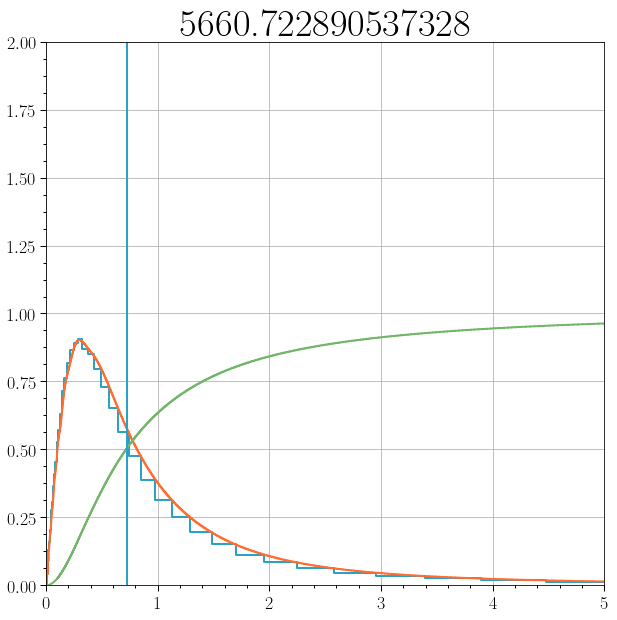

1.2674392678836745e-08


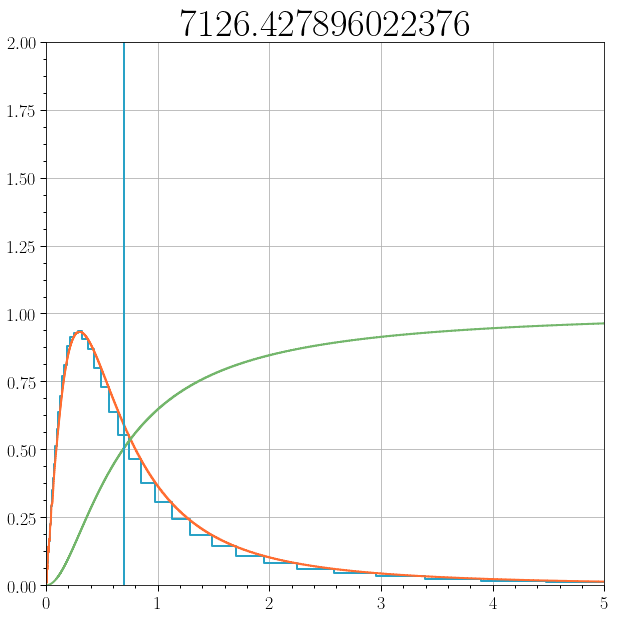

1.1413755264912582e-08


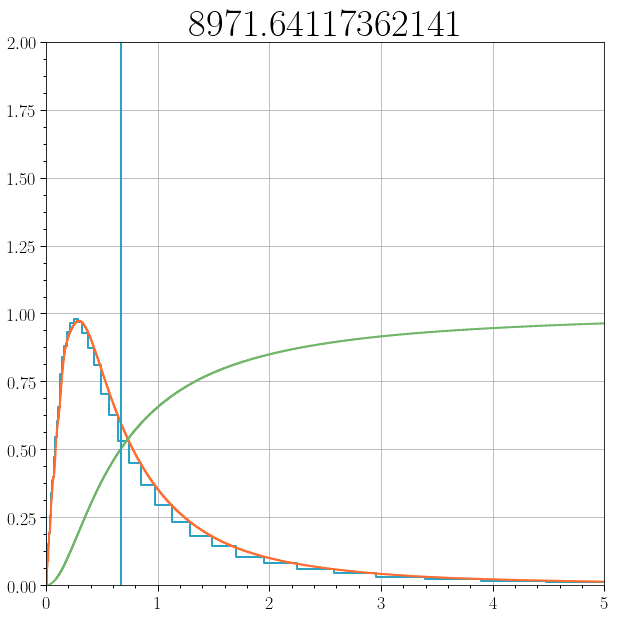

1.3935254229183735e-08


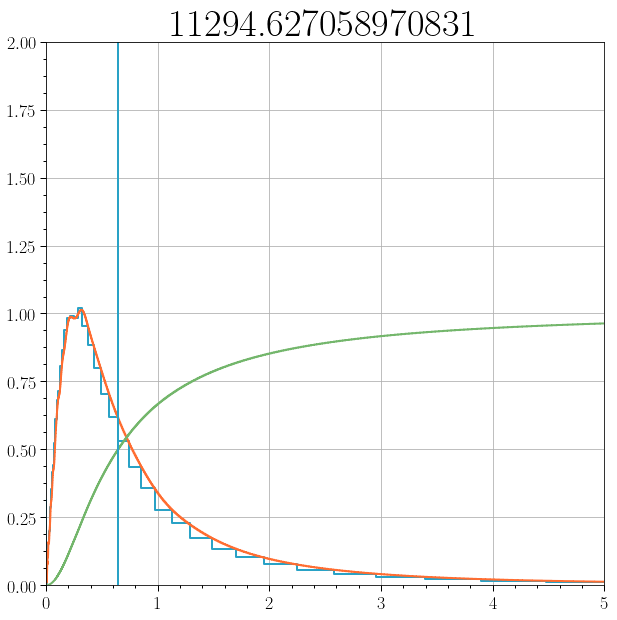

1.0492796100179202e-08


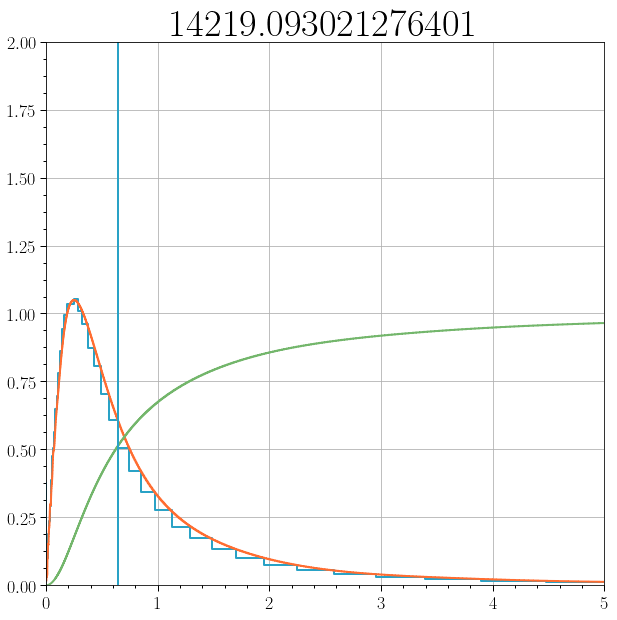

1.3958080482981296e-08


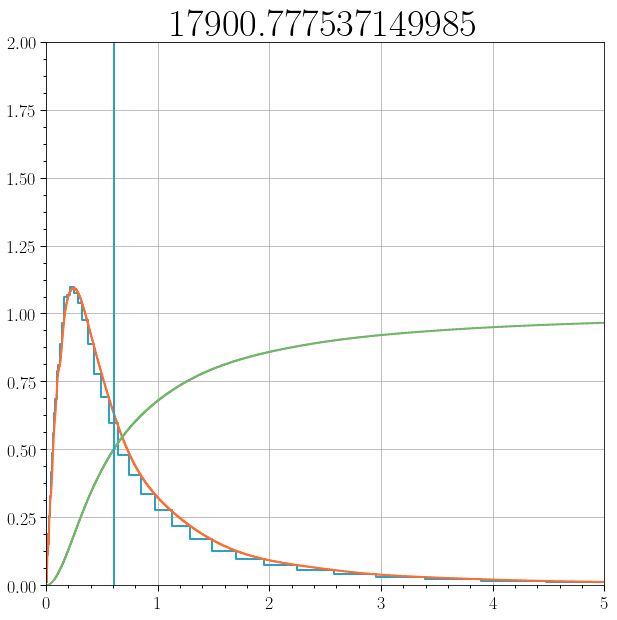

1.3166449170880671e-08


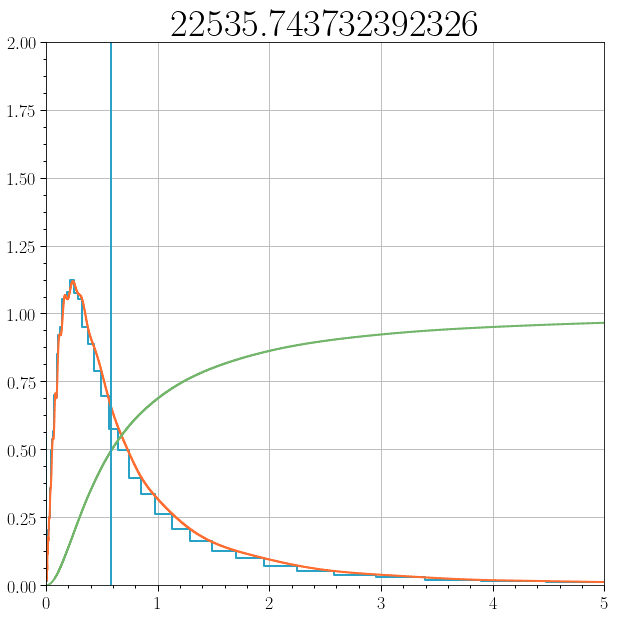

1.1562364350657985e-08


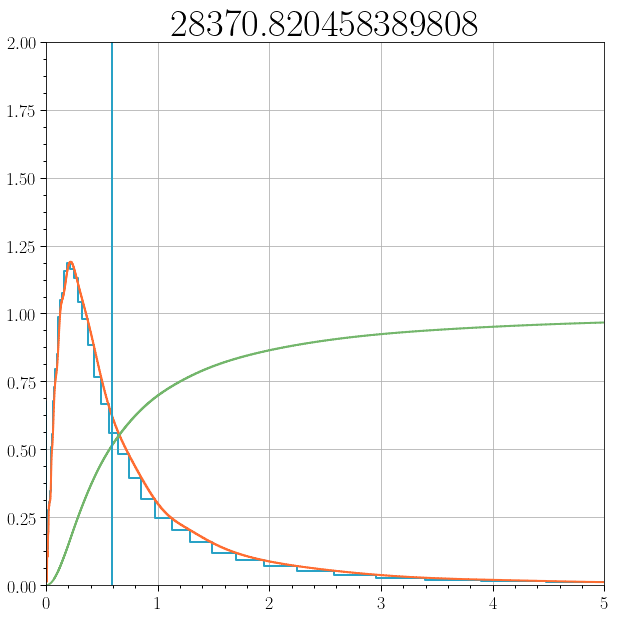

1.3731674930327969e-08


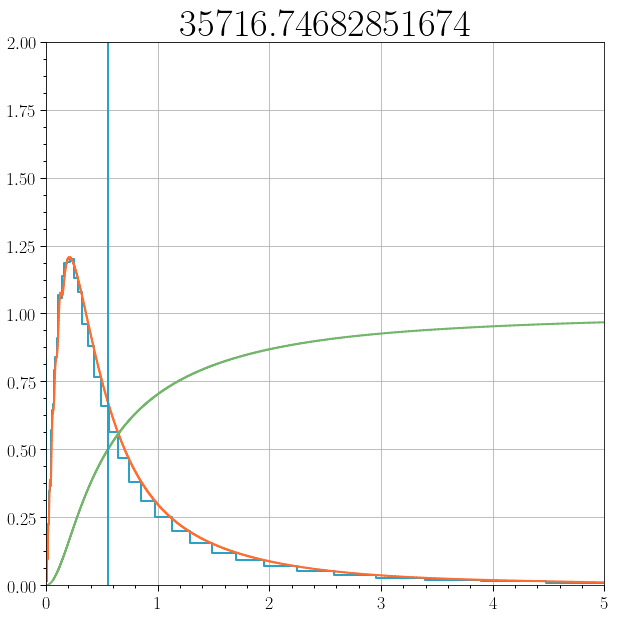

1.2294210556474855e-08


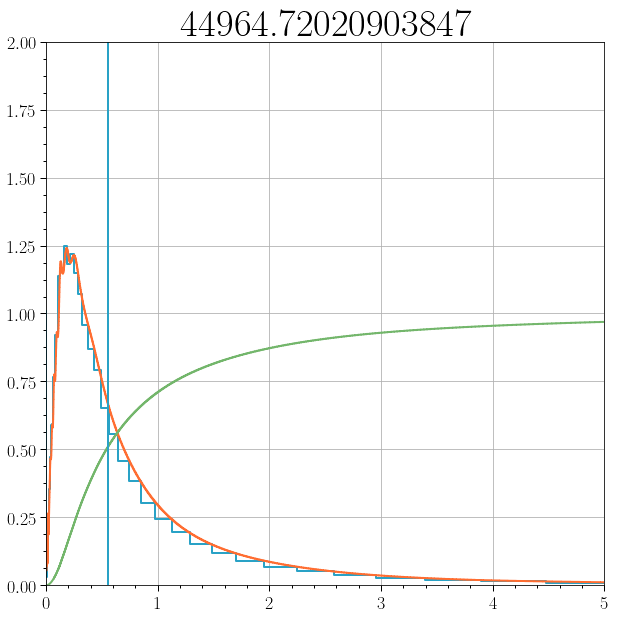

1.3868156982423884e-08


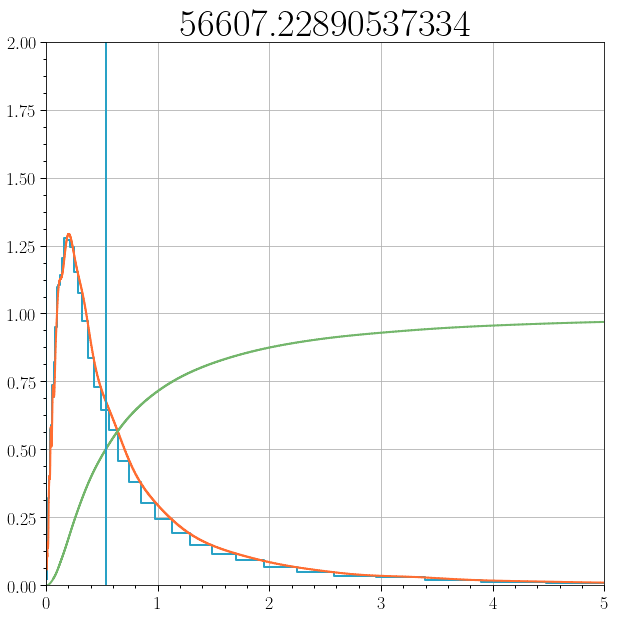

1.4107915795642703e-08


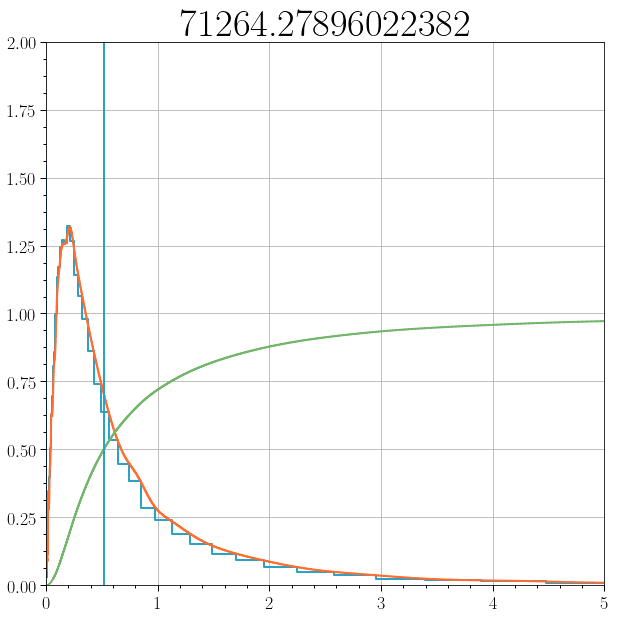

1.3907208479843053e-08


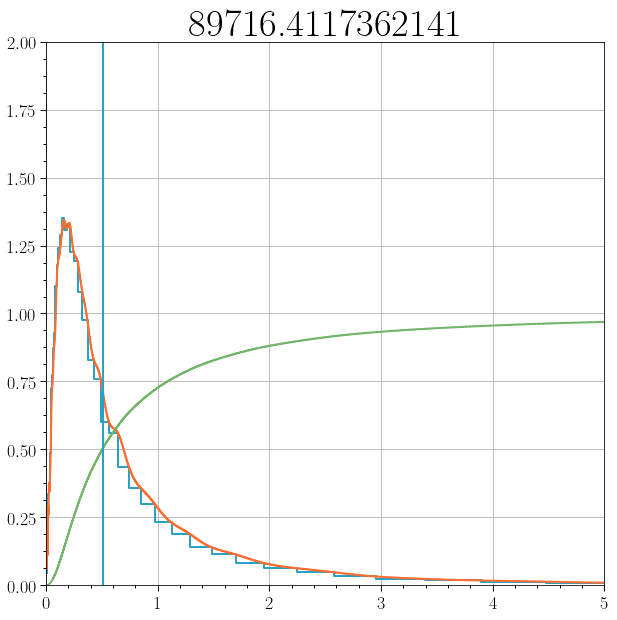

1.2843725794256191e-08


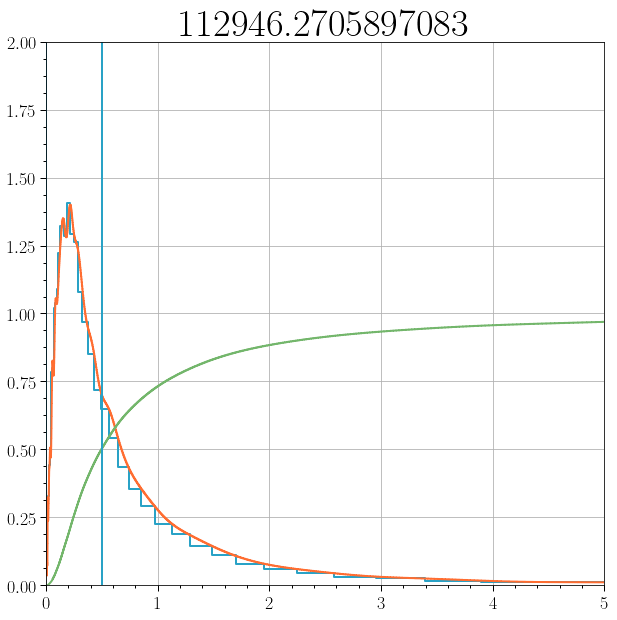

1.3532526570383029e-08


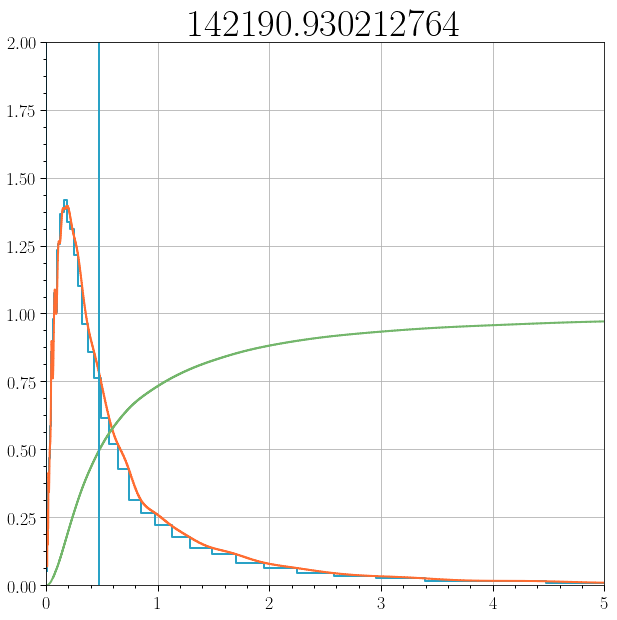

1.2628479949927857e-08


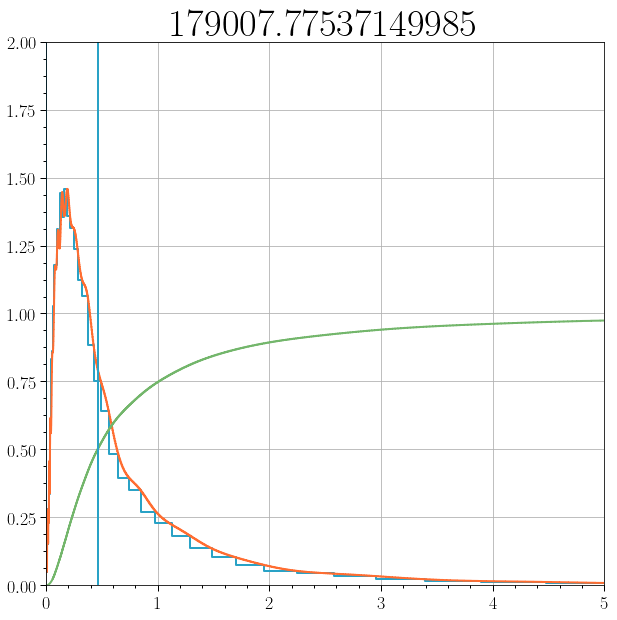

1.2487546373037727e-08


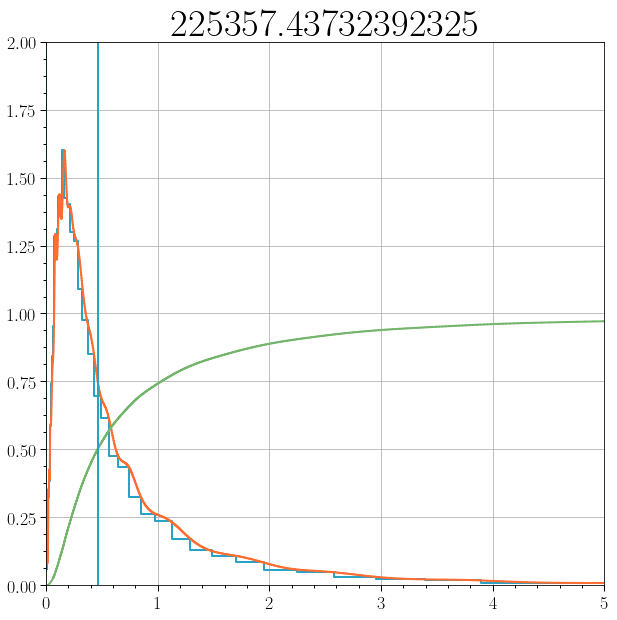

1.2763334504705836e-08


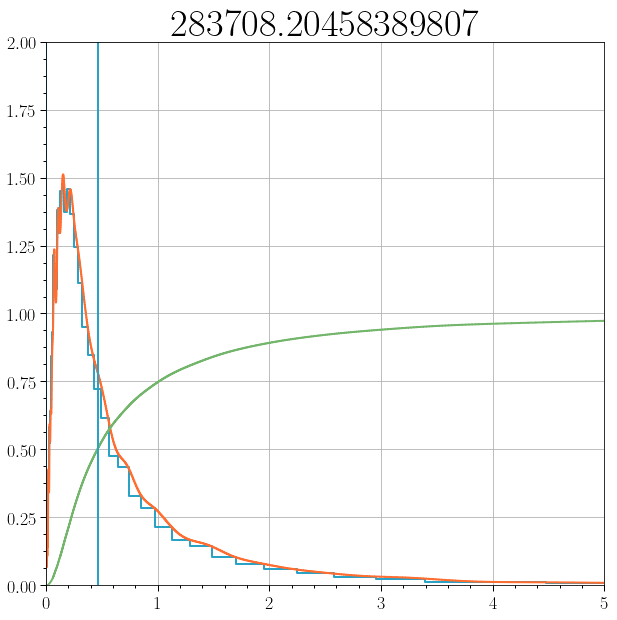

1.270998558883441e-08


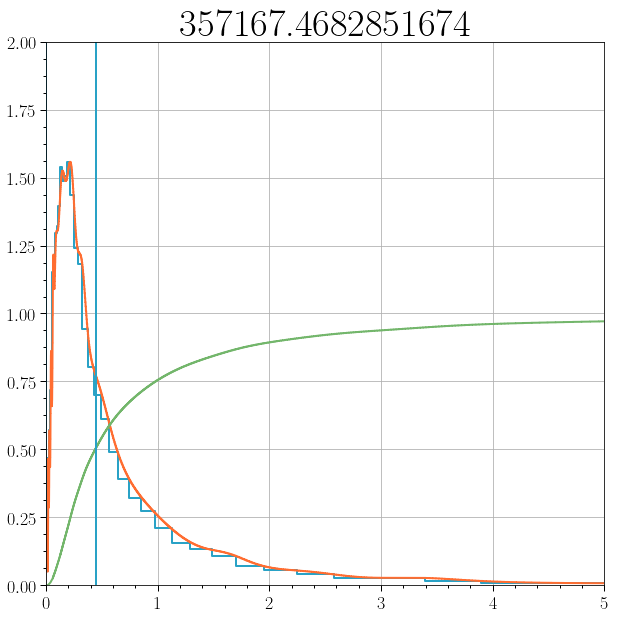

1.260296077990667e-08


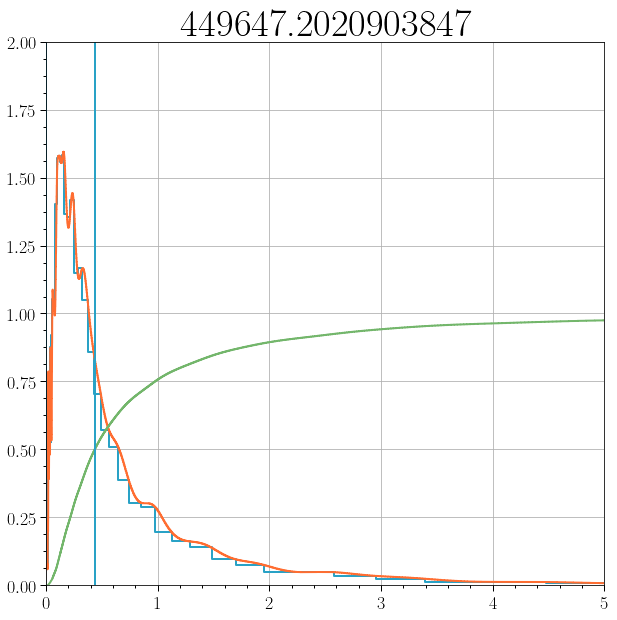

1.3978670002215945e-08


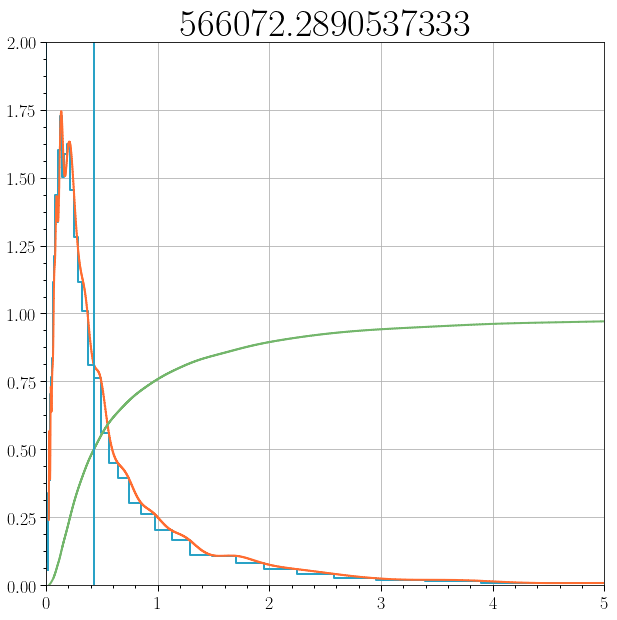

1.2452259051414279e-08


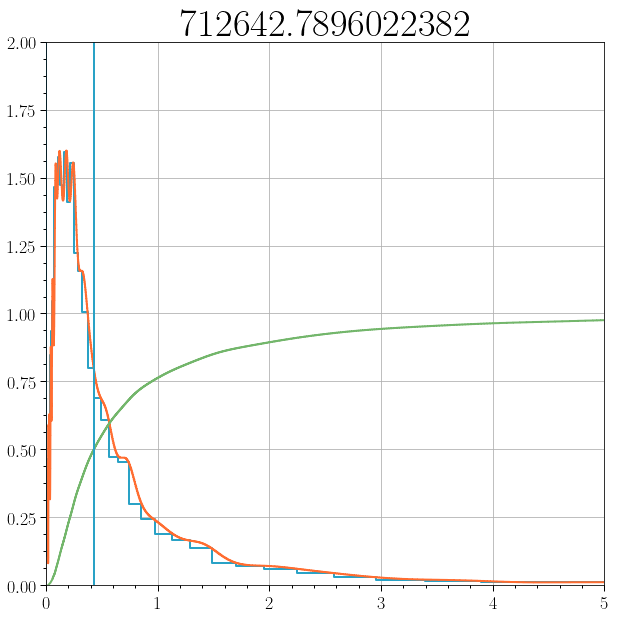

1.3420077475589776e-08


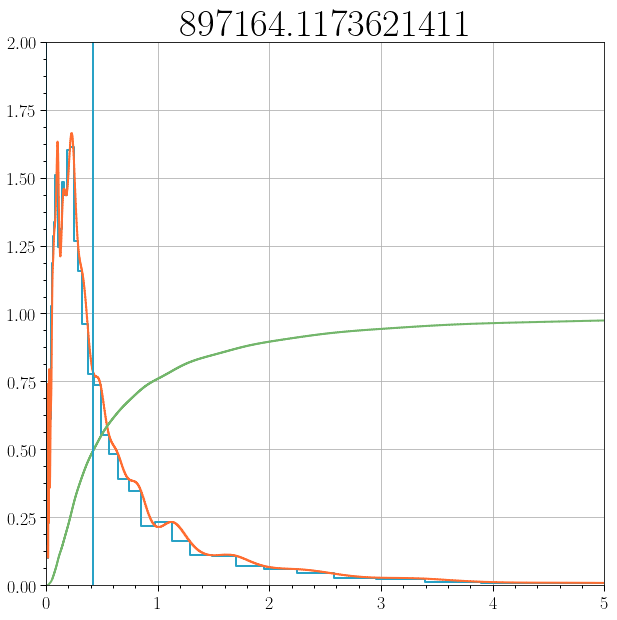

In [17]:
# e_cents = (e_bins[:-1]+e_bins[1:])/2
med_error = []
norms     = []
for j, arr in enumerate(h[0][3:]):
    
    i0, i1 = get_zeros_outta_there(arr)
    arr    = np.concatenate([np.ones(i0), arr[i0:i1], np.ones(len(arr)-i1)])
    delta_psi_centers_good = delta_psi_centers[i0:i1]
    
    dn_dtheta = arr / np.log(10) / delta_psi_centers
    
    f   = UnivariateSpline(np.log10(delta_psi_centers), np.log10(dn_dtheta), k=5, s=1e-3)
#     f   = UnivariateSpline(np.log10(delta_psi_centers), np.log10(dn_dtheta), k=5, s=1e-5)
    
    
    def dn_dtheta_interp(x):
        logx = f(np.log10(x))
        return np.power(10, logx)
    
    def cdf(y, norm):

        i = integrate.quad(lambda x: np.exp(x)*dn_dtheta_interp(np.exp(x)), np.log(delta_psi_centers_good)[0], np.log(y))
        return i[0] / norm

    i = integrate.quad(lambda x: np.exp(x)*dn_dtheta_interp(np.exp(x)), np.log(delta_psi_centers_good)[0], np.log(delta_psi_centers_good)[-1])


    print(i[1] / i[0])
    norm = i[0]
    norms.append(norm)
    
    xx = np.logspace(np.log10(delta_psi_centers_good[0]), np.log10(delta_psi_centers_good[-1]), 1001)
    yy = [cdf(x, norm) for x in xx]
    spline = dn_dtheta_interp(xx)
    
    p      = (spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm / sum((spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm)
    median = np.median(np.random.choice((xx[1:]+xx[:-1])/2, 10000, p=p))
    med_error.append(median)
    
    plt.step(delta_psi_centers, dn_dtheta / norm)
    plt.step(xx,spline / norm)
    plt.step(xx,yy)
#     plt.semilogx()

    plt.axvline(median)
    
    plt.title(nue_cents[j+3])
    plt.xlim(1e-3,5)
    plt.ylim(0,2)
    plt.grid()
    plt.show()

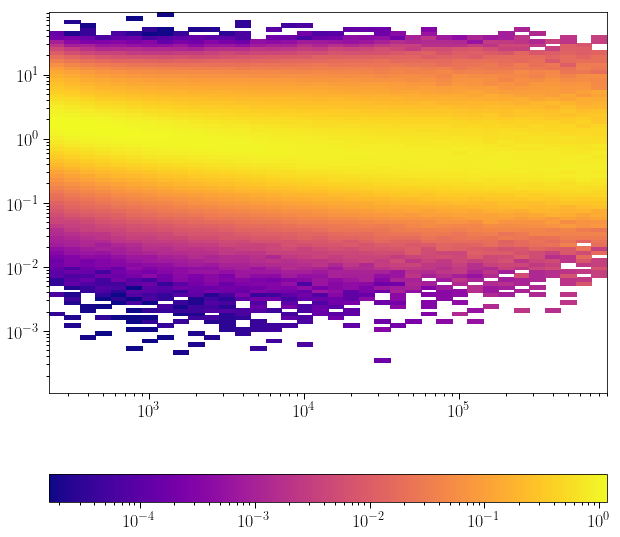

In [18]:
h = np.histogram2d(log10nuE, opening_angles, bins=[log10e_edges, delta_psi_edges])

X,Y=np.meshgrid(nue_cents[3:],delta_psi_centers)

hist = (h[0][3:].T / [norms for i in range(100)])
im = plt.pcolor(X, Y, hist, norm=LogNorm())

plt.xscale('log')
plt.yscale('log')

plt.colorbar(im, orientation='horizontal',format=LogFormatterMathtext())

plt.show()
# print(np.divide(h[0][3:], norms, axis=0) )

In [19]:
# # e_cents = (e_bins[:-1]+e_bins[1:])/2
# med_error = []
# norms     = []
# for j, arr in enumerate(h[0][3:]):
    
#     i0, i1 = get_zeros_outta_there(arr)
#     arr    = np.concatenate([np.ones(i0), arr[i0:i1], np.ones(len(arr)-i1)])
#     delta_psi_centers_good = delta_psi_centers[i0:i1]
    
#     dn_dtheta = arr / np.log(10) / delta_psi_centers
    
#     f   = UnivariateSpline(np.log10(delta_psi_centers), np.log10(dn_dtheta), k=5, s=1e-4)
# #     f   = UnivariateSpline(np.log10(delta_psi_centers), np.log10(dn_dtheta), k=5, s=1e-5)
    
    
#     def dn_dtheta_interp(x):
#         logx = f(np.log10(x))
#         return np.power(10, logx)
    
#     def cdf(y, norm):

#         i = integrate.quad(lambda x: np.exp(x)*dn_dtheta_interp(np.exp(x)), np.log(delta_psi_centers_good)[0], np.log(y))
#         return i[0] / norm

#     i = integrate.quad(lambda x: np.exp(x)*dn_dtheta_interp(np.exp(x)), np.log(delta_psi_centers_good)[0], np.log(delta_psi_centers_good)[-1])


#     print(i[1] / i[0])
#     norm = i[0]
#     norms.append(norm)
    
#     xx = np.logspace(np.log10(delta_psi_centers_good[0]), np.log10(delta_psi_centers_good[-1]), 1001)
#     yy = [cdf(x, norm) for x in xx]
#     spline = dn_dtheta_interp(xx)
    
#     p      = (spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm / sum((spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm)
#     median = np.median(np.random.choice((xx[1:]+xx[:-1])/2, 10000, p=p))
#     med_error.append(median)
    
#     plt.step(delta_psi_centers, dn_dtheta / norm)
#     plt.step(xx,spline / norm)
#     plt.step(xx,yy)
# #     plt.semilogx()

#     plt.axvline(median)
    
#     plt.title(nue_cents[j+3])
#     plt.xlim(1e-3,5)
#     plt.ylim(0,2)
#     plt.grid()
#     plt.show()

In [20]:
# p = (spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm / sum((spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm)
# np.median(np.random.choice((xx[1:]+xx[:-1])/2, 10000, p=p))

0.4269807058916873

In [21]:
# sum((spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm)

1.0000081749066736

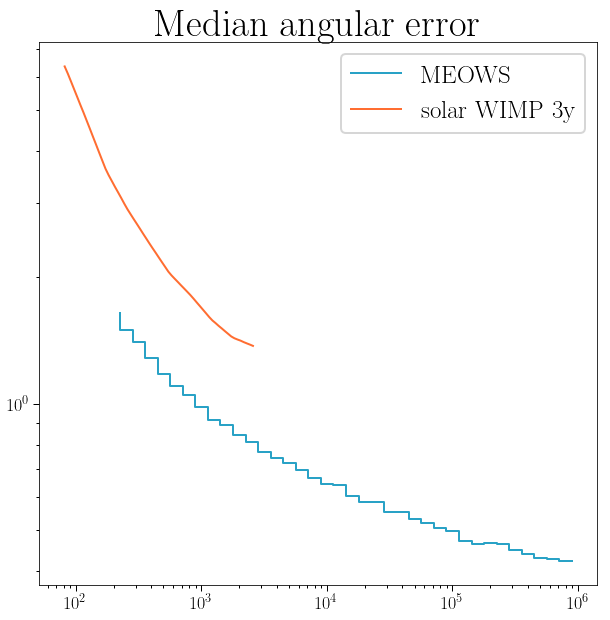

In [22]:
_ = np.genfromtxt("/Users/jlazar/Downloads/3y_solar_WIMP_ang_res.csv", delimiter=",").T
old_e   = _[0]
old_res = _[1]

plt.step(nue_cents[3:], med_error, label="MEOWS")
plt.plot(old_e, old_res, label="solar WIMP 3y")
plt.loglog()

plt.title("Median angular error")
plt.legend()

plt.show()


In [30]:
MEOWS_spline = UnivariateSpline(np.log10(nue_cents[3:]), np.log10(med_error), k=3, )
solar_WIMP_3y_spline = UnivariateSpline(np.log10(old_e), np.log10(old_res), k=3, )

def MEOWS_error(nu_e):
    log10err = MEOWS_spline(np.log10(nu_e))
    return 10**log10err

def sw_3y_error(nu_e):
    log10err = solar_WIMP_3y_spline(np.log10(nu_e))
    return 10**log10err

def ratio(nu_e):
    return np.divide(sw_3y_error(nu_e), MEOWS_error(nu_e))

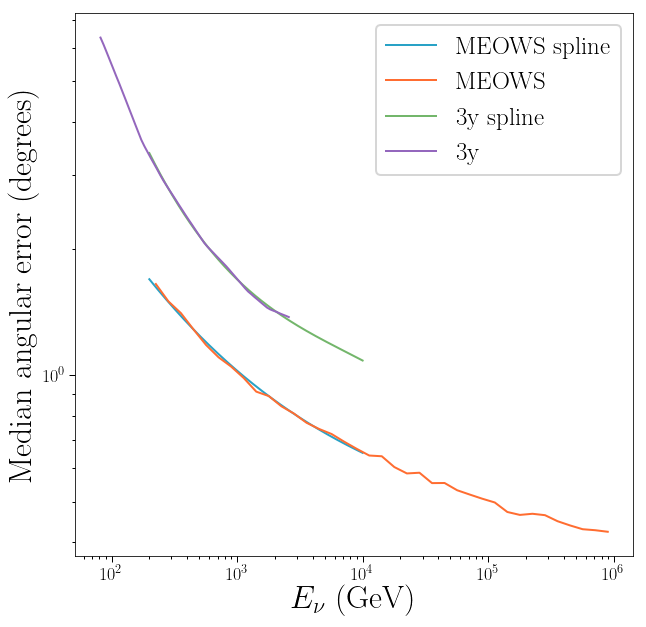

In [24]:
plt.plot(np.logspace(np.log10(200),4,1000),MEOWS_error(np.logspace(np.log10(200),4,1000)), label="MEOWS spline")
plt.plot(nue_cents[3:], med_error, label="MEOWS")
plt.plot(np.logspace(np.log10(200),4,1000), sw_3y_error(np.logspace(np.log10(200),4,1000)), label="3y spline")
plt.plot(old_e, old_res, label="3y")

plt.xlabel(r"$E_{\nu}$ (GeV)")
plt.ylabel(r"Median angular error (degrees)")

plt.legend()

plt.loglog()

plt.show()

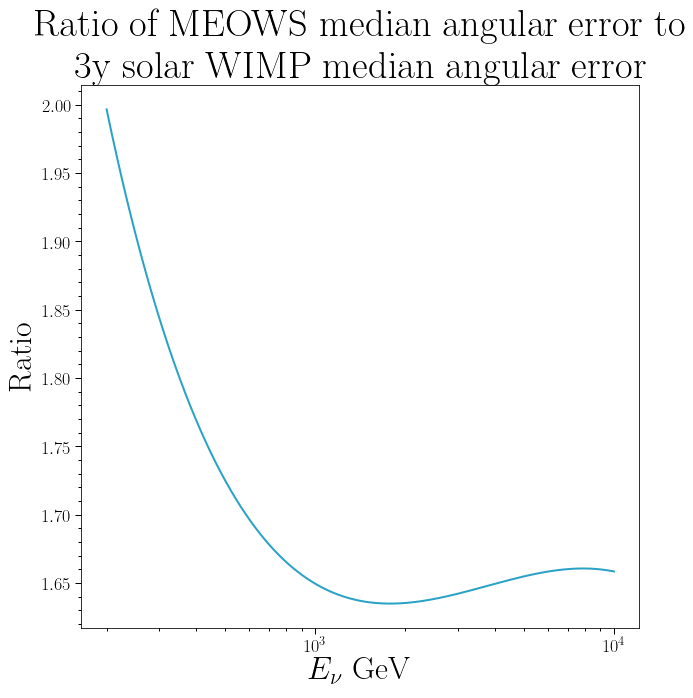

In [25]:
plt.plot(np.logspace(np.log10(200),4,1000), ratio(np.logspace(np.log10(200),4,1000)),)

plt.ylabel("Ratio")
plt.xlabel(r"$E_{\nu}$ GeV")
plt.title("Ratio of MEOWS median angular error to\n 3y solar WIMP median angular error")

plt.semilogx()

plt.show()

In [47]:
# arr = np.full(len(log10nuE), np.nan)
gen_op_ang = np.multiply(ratio(np.power(10,log10nuE)), 
                            np.radians(opening_angles), 
                            where=~(log10nuE>4), 
                            out=np.full(len(log10nuE), np.nan))
gen_az = np.random.rand(len(gen_op_ang))*2*np.pi
print(scaled_op_ang)

[0.04544606 0.07788807        nan ... 0.01976547 0.01232888 0.0355624 ]


In [51]:
r_az, r_zen = rotate_coords(nuAzs, nuZens, gen_az, gen_op_ang)

In [52]:
opening_angle(r_zen, r_az, nuZens, nuAzs)

array([0.04544606, 0.07788807,        nan, ..., 0.01976547, 0.01232888,
       3.13876467])

In [55]:
arr = np.recarray(len(r_az), 
                  dtype=[("rescaled_reco_az", float),
                         ("rescaled_reco_zen", float)]
                 )
arr["rescaled_reco_az"][:] = r_az
arr["rescaled_reco_zen"][:] = r_zen

In [59]:
np.save("/Users/jlazar/Documents/IceCube/solar_WIMP/data/rescaled_reco_angles.npy", arr)

1.405023432281372e-08


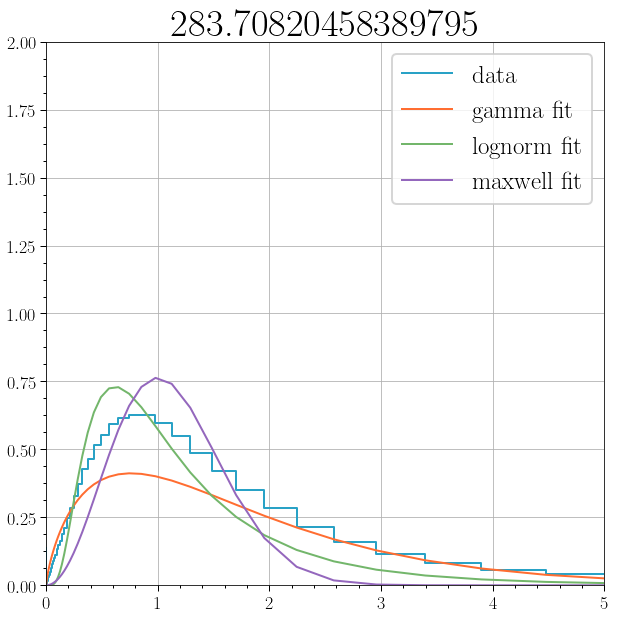

In [523]:
arr = h[0][4]

i0, i1 = get_zeros_outta_there(arr)
arr    = np.concatenate([np.ones(i0), arr[i0:i1], np.ones(len(arr)-i1)])
delta_psi_centers_good = delta_psi_centers[i0:i1]

dn_dtheta = arr / np.log(10) / delta_psi_centers

f   = UnivariateSpline(np.log10(delta_psi_centers), np.log10(dn_dtheta), k=5, s=1e-5)


# def dn_dtheta_interp(x):
#     logx = f(np.log10(x))
#     return np.power(10, logx)

# def cdf(y, norm):

#     i = integrate.quad(lambda x: np.exp(x)*dn_dtheta_interp(np.exp(x)), np.log(delta_psi_centers_good)[0], np.log(y))
#     return i[0] / norm

# i = integrate.quad(lambda x: np.exp(x)*dn_dtheta_interp(np.exp(x)), np.log(delta_psi_centers_good)[0], np.log(delta_psi_centers_good)[-1])


print(i[1] / i[0])
norm = norms[0]
# norms.append(norm)

xx = np.logspace(np.log10(delta_psi_centers_good[0]), np.log10(delta_psi_centers_good[-1]), 1001)
# yy = [cdf(x, norm) for x in xx]
spline = dn_dtheta_interp(xx)

# Find median of distribution
p      = (spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm / sum((spline[1:]+spline[:-1])/2*(xx[1:]-xx[:-1])/norm)
median = np.median(np.random.choice((xx[1:]+xx[:-1])/2, 10000, p=p))

dp_dtheta = dn_dtheta / norm

popt_gamma, pcov_gamma = curve_fit(gamma.pdf, delta_psi_centers,dp_dtheta, p0=[1])
popt_logn, pcov_logn   = curve_fit(lognorm.pdf, delta_psi_centers,dp_dtheta, p0=[1])
popt_max, pcov_max   = curve_fit(maxwell, delta_psi_centers,dp_dtheta, p0=[1])


    
plt.step(delta_psi_centers, dp_dtheta, label="data")
# plt.step(xx,spline / norm)
plt.plot(delta_psi_centers,gamma.pdf(delta_psi_centers,*popt_gamma), label='gamma fit')
plt.plot(delta_psi_centers,lognorm.pdf(delta_psi_centers,*popt_logn), label='lognorm fit')
plt.plot(delta_psi_centers,maxwell(delta_psi_centers,*popt_max), label='maxwell fit')
# plt.step(xx,yy)
# plt.semilogx()

plt.legend()
# plt.axvline(median)

plt.title(nue_cents[4])
plt.xlim(1e-3,5)
plt.ylim(0,2)
plt.grid()
plt.show()

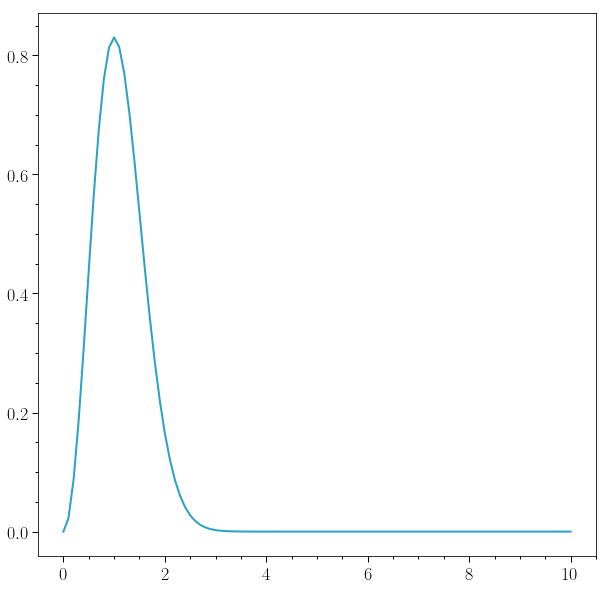

In [521]:
plt.plot(np.linspace(0, 10, 101), maxwell(np.linspace(0, 10, 101),1))